# Carga y evaluación de los modelos

Descomprimimos la carpeta con los modelos

# Pasos previos

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import seaborn as sns   
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2019-01-01'
fecha_inicio_test = '2019-01-02'
fecha_fin_test = '2019-05-01'

datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

scaler_tesla =  MinMaxScaler(feature_range=(0,1))
scaler_sp500 =  MinMaxScaler(feature_range=(0,1))
scaler_bitcoin =  MinMaxScaler(feature_range=(0,1))
scaler_petroleo =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler_tesla.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler_sp500.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler_bitcoin.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler_petroleo.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla


def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train


datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test) 
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler_tesla.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler_sp500.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler_bitcoin.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler_petroleo.transform(np.array(datos_petroleo_test).reshape(-1,1))

def evaluate_model(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

def evaluate_model_seguidos(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:11], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:10], label=name, color='blue')
    ax.set_title(name)

def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(2142, 1) (2264, 1) (1567, 1) (2262, 1)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Redes neuronales

In [6]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)

# LSTM

2/2 [==============================] - 0s 48ms/step
Tesla (TSLA)
RMSE:  0.8735505601241154
MSE:  0.7630905810931556
MAE:  0.7065186500549316
R²:  0.45072840679262327


2/2 [==============================] - 0s 19ms/step
SP500 (^GSPC)
RMSE:  19.576642926287228
MSE:  383.2449482633517
MAE:  15.614999624399038
R²:  0.8755020128271342


3/3 [==============================] - 0s 37ms/step
Bitcoin (BTC-USD)
RMSE:  222.78153051394108
MSE:  49631.610338134065
MAE:  204.0954315528441
R²:  0.8834235366724738


2/2 [==============================] - 0s 19ms/step
Petroleo (CL=F)
RMSE:  0.9254846123131829
MSE:  0.8565217676284824
MAE:  0.7310497577373803
R²:  0.9333232925670596




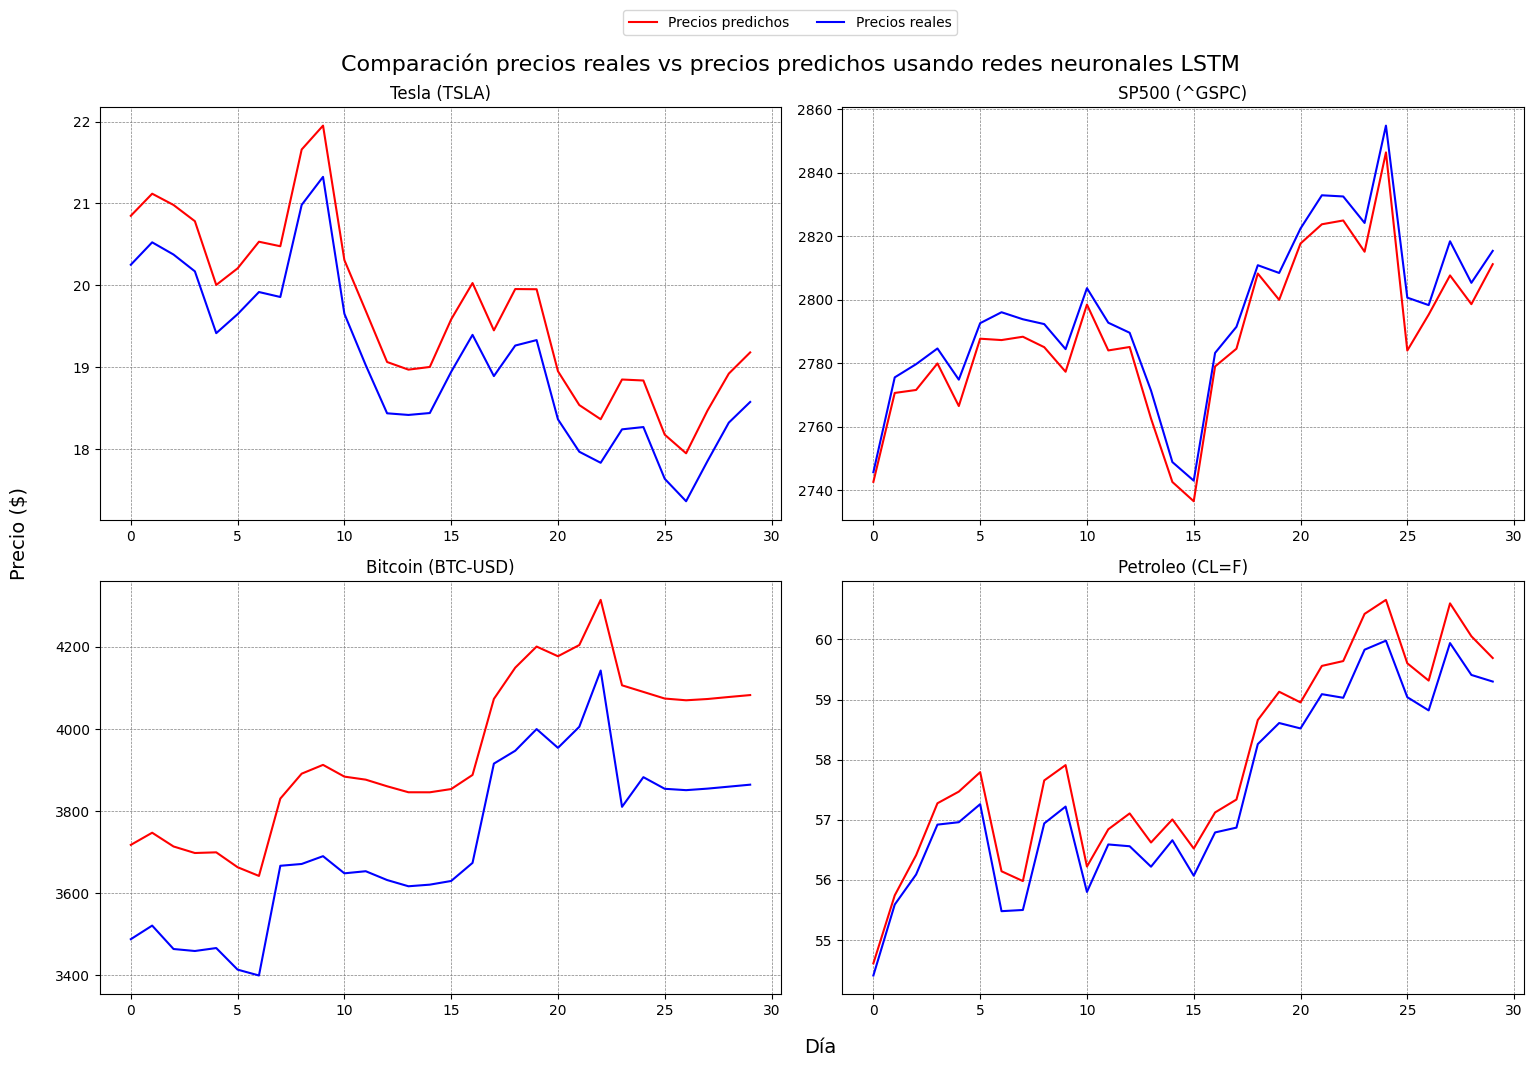

Tesla (TSLA)
RMSE:  1.1460954130682866
MSE:  1.3135346958561664
MAE:  0.9545096079508464
R²:  -3.5322615948714233


SP500 (^GSPC)
RMSE:  91.4484267978422
MSE:  8362.814763800303
MAE:  88.66891276041666
R²:  -13.63000632861874


Bitcoin (BTC-USD)
RMSE:  568.7085891492226
MSE:  323429.45937209926
MAE:  562.3685872395833
R²:  -125.27108857361405


Petroleo (CL=F)
RMSE:  7.340727004858995
MSE:  53.88627295986612
MAE:  7.218585459391276
R²:  -20.57848161831599




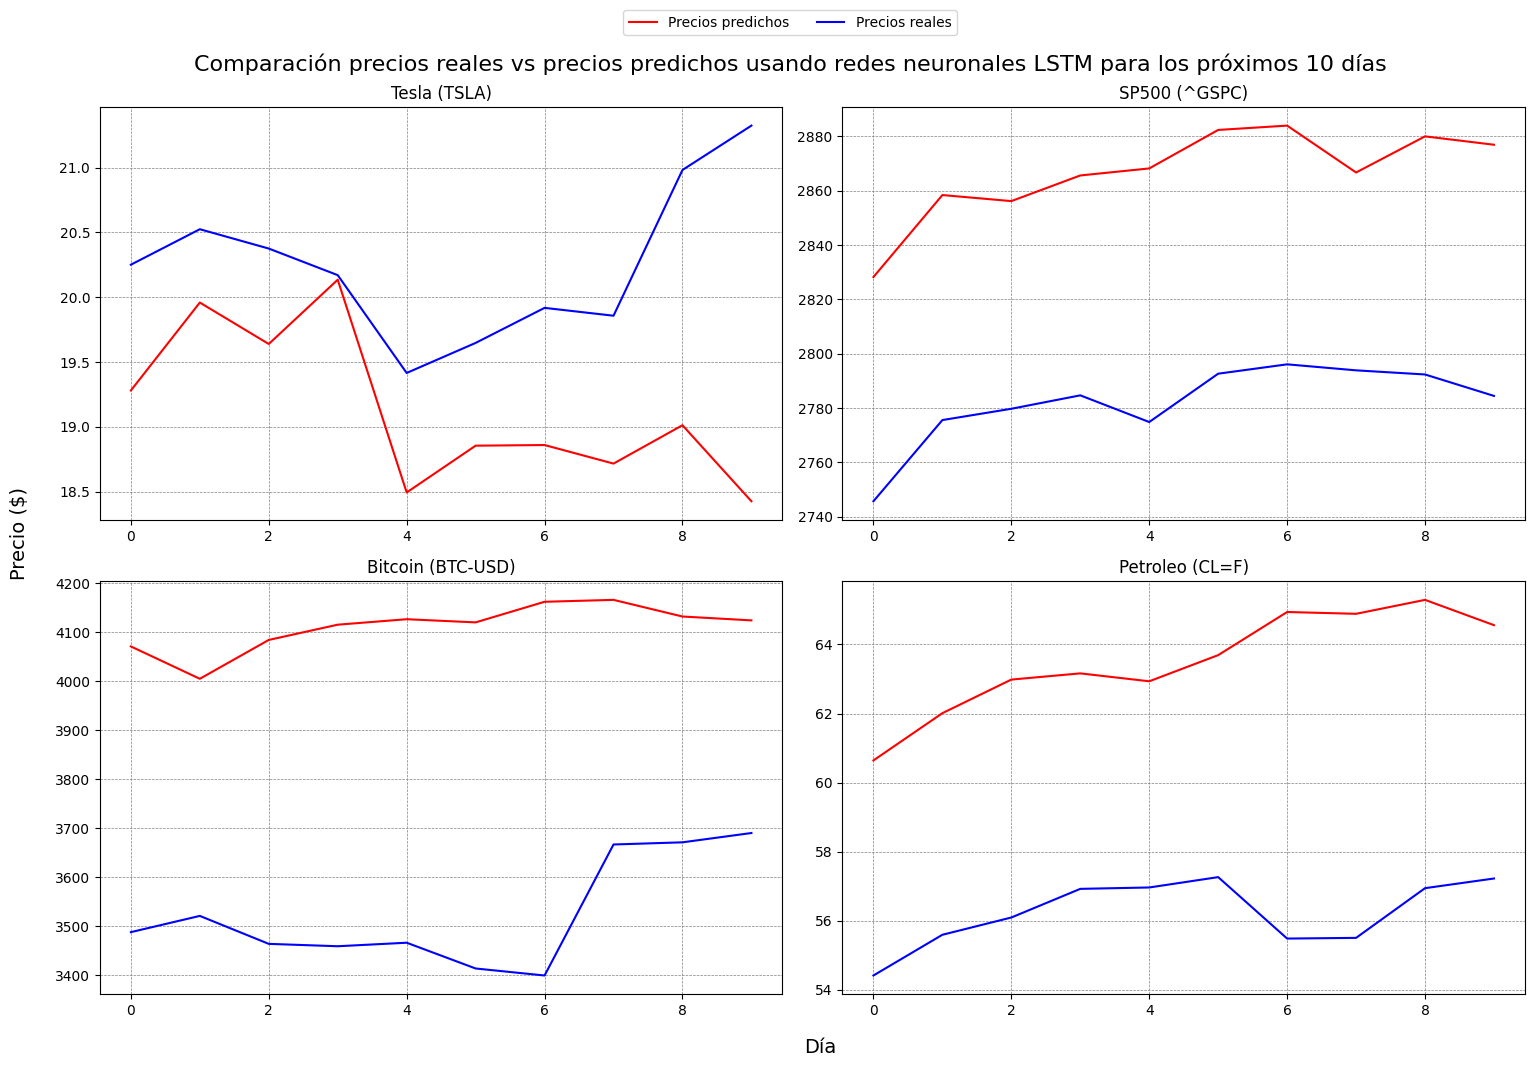

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = tf.keras.models.load_model('modelos/lstm_tesla.h5')
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

lstm_sp500 = tf.keras.models.load_model('modelos/lstm_sp500.h5')
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

lstm_bitcoin = tf.keras.models.load_model('modelos/stm_bitcoin.h5')
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

lstm_petroleo = tf.keras.models.load_model('modelos/lstm_petroleo.h5')
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [8]:
lstm_tesla.summary()

Model: "sequential_196"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_588 (LSTM)             (None, None, 512)         1052672   
                                                                 
 lstm_589 (LSTM)             (None, None, 512)         2099200   
                                                                 
 lstm_590 (LSTM)             (None, 512)               2099200   
                                                                 
 dense_196 (Dense)           (None, 1)                 513       
                                                                 
Total params: 5,251,585
Trainable params: 5,251,585
Non-trainable params: 0
_________________________________________________________________


In [9]:
lstm_sp500.summary()

Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_591 (LSTM)             (None, None, 256)         264192    
                                                                 
 lstm_592 (LSTM)             (None, None, 256)         525312    
                                                                 
 lstm_593 (LSTM)             (None, 256)               525312    
                                                                 
 dense_197 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [10]:
lstm_bitcoin.summary()

Model: "sequential_198"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_594 (LSTM)             (None, None, 256)         264192    
                                                                 
 lstm_595 (LSTM)             (None, None, 256)         525312    
                                                                 
 lstm_596 (LSTM)             (None, 256)               525312    
                                                                 
 dense_198 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [11]:
lstm_petroleo.summary()

Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_597 (LSTM)             (None, None, 256)         264192    
                                                                 
 lstm_598 (LSTM)             (None, None, 256)         525312    
                                                                 
 lstm_599 (LSTM)             (None, 256)               525312    
                                                                 
 dense_199 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


# GRU

2/2 [==============================] - 0s 28ms/step
Tesla (TSLA)
RMSE:  0.6751216072639472
MSE:  0.45578918459465545
MAE:  0.5039232143988976
R²:  0.6600363578202624


2/2 [==============================] - 0s 8ms/step
SP500 (^GSPC)
RMSE:  17.49268018836844
MSE:  305.99386017253767
MAE:  13.167062612680288
R²:  0.9061539455037902


3/3 [==============================] - 0s 14ms/step
Bitcoin (BTC-USD)
RMSE:  703.705664427222
MSE:  495201.66214695806
MAE:  692.9623474806882
R²:  -0.32562747564669925


2/2 [==============================] - 0s 15ms/step
Petroleo (CL=F)
RMSE:  0.9473268862577655
MSE:  0.8974282294268333
MAE:  0.77620293543889
R²:  0.9298243697007261




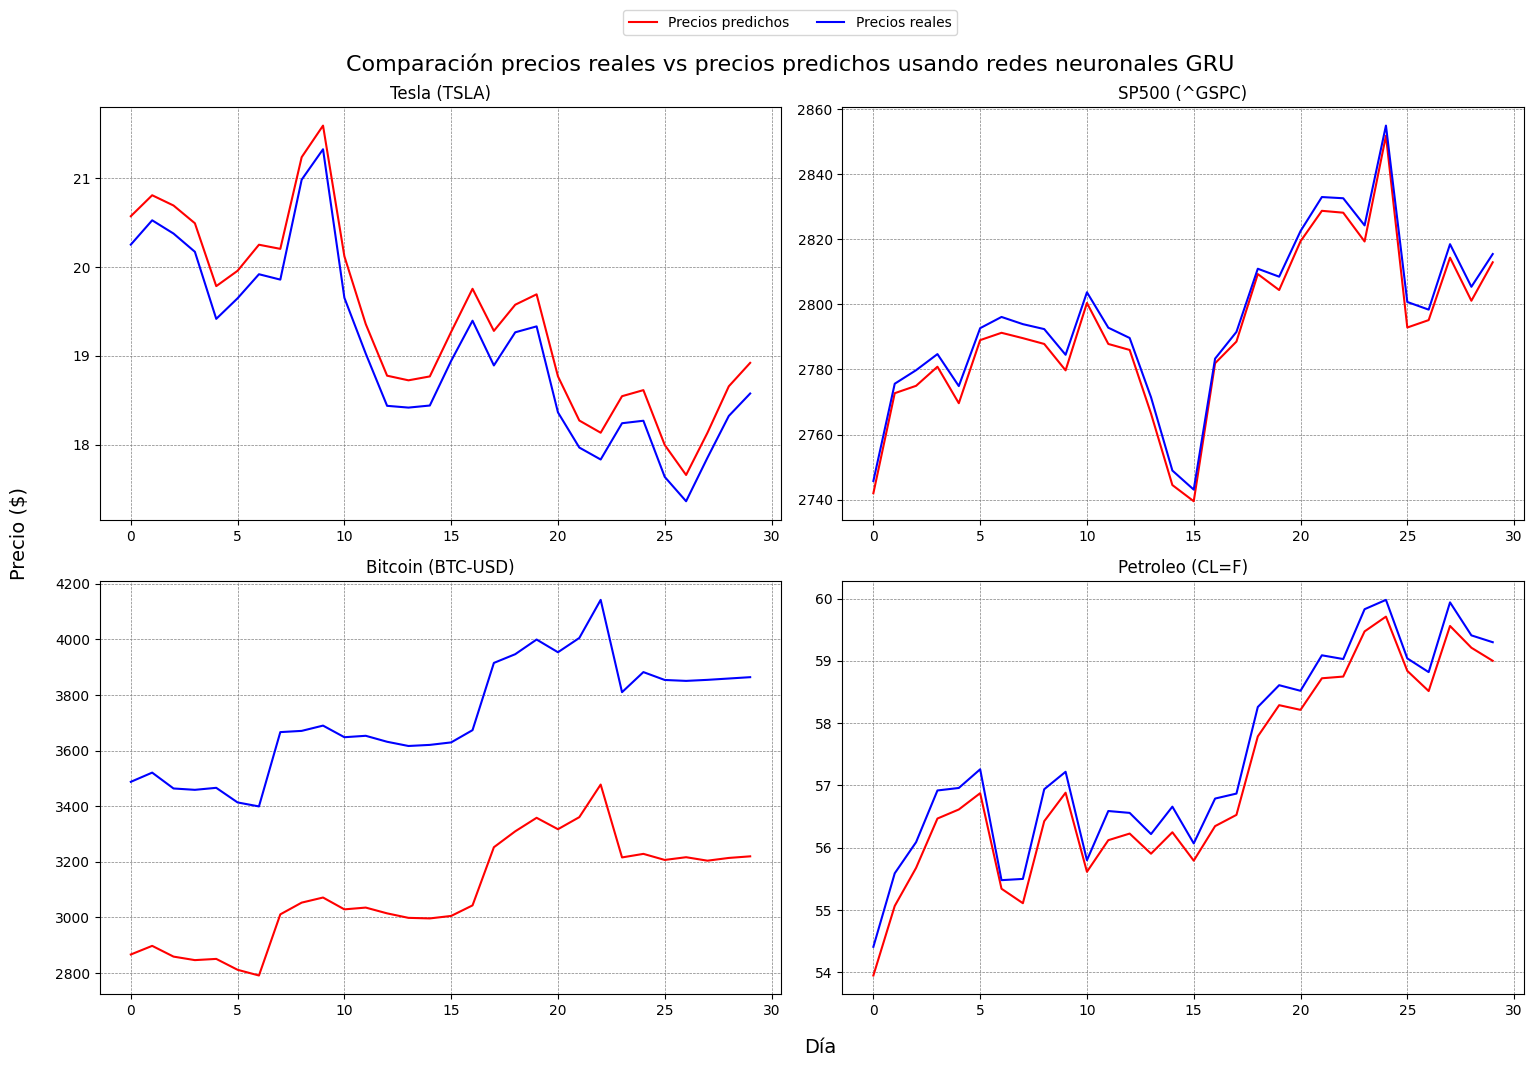

Tesla (TSLA)
RMSE:  1.3304024356784125
MSE:  1.7699706408590525
MAE:  1.1038674672444662
R²:  -5.838119164062718


SP500 (^GSPC)
RMSE:  96.60264095084389
MSE:  9332.070238677661
MAE:  93.88447265625
R²:  -14.172057978233209


Bitcoin (BTC-USD)
RMSE:  309.1904958663435
MSE:  95598.76273407538
MAE:  296.9836751302083
R²:  -30.946304723426575


Petroleo (CL=F)
RMSE:  6.51119309834656
MSE:  42.39563556395587
MAE:  6.3773244222005205
R²:  -16.774228907564968




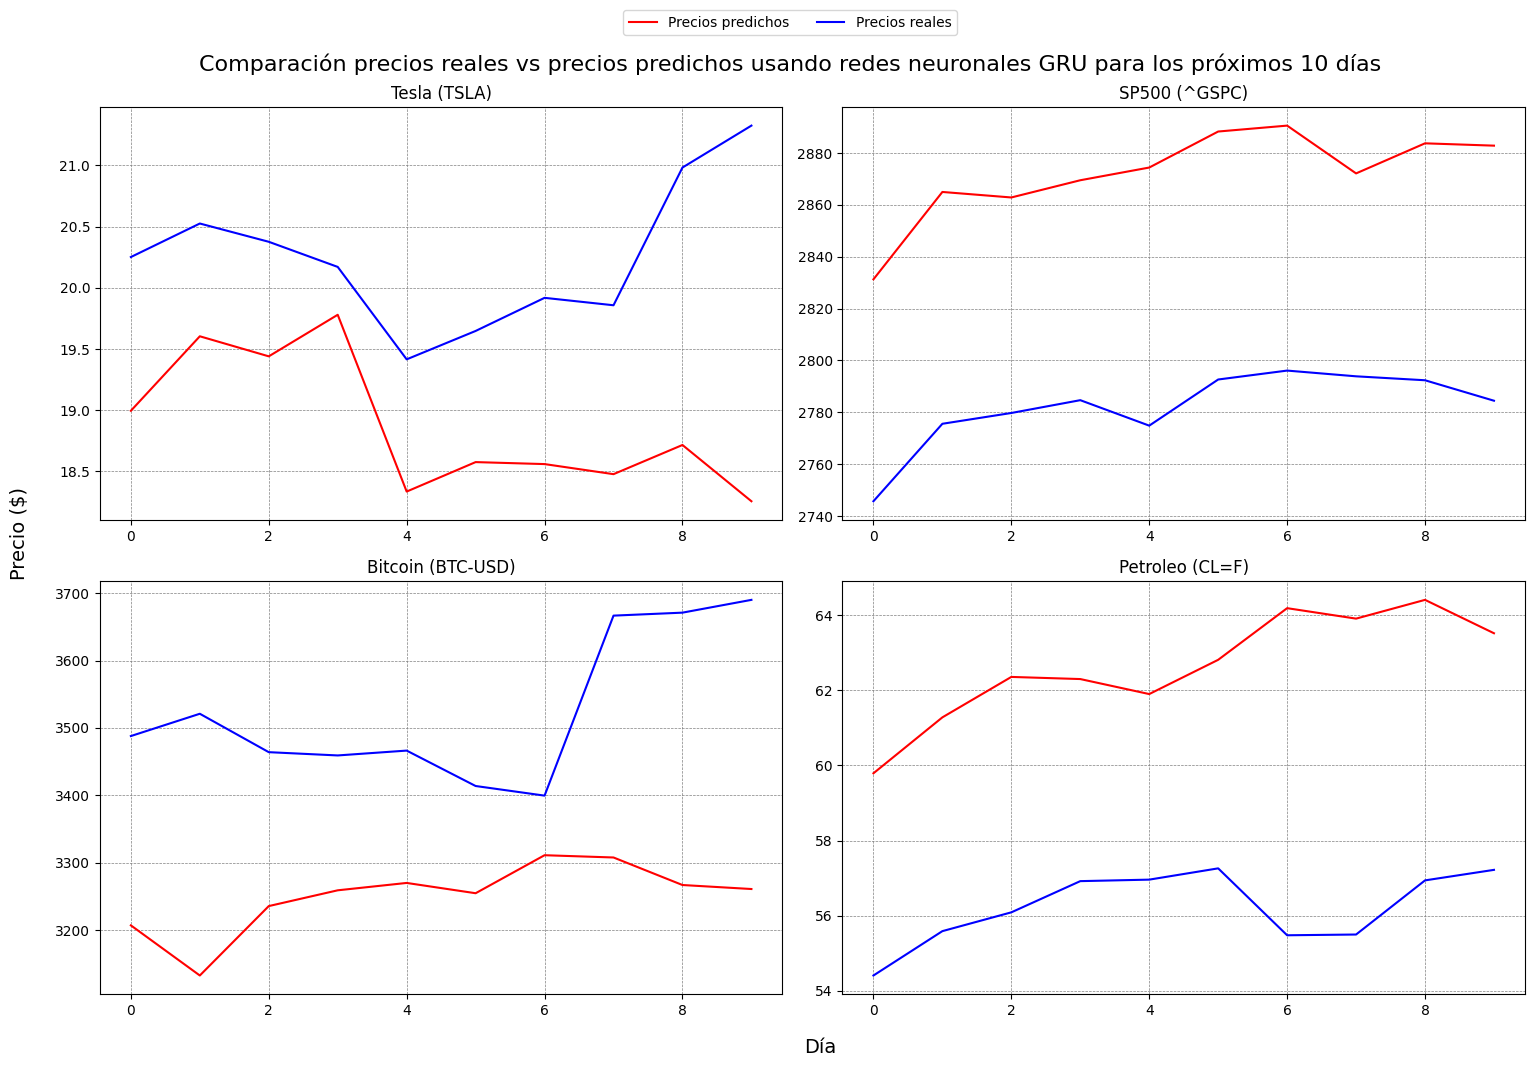

In [12]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

gru_tesla = tf.keras.models.load_model('modelos/gru_tesla.h5')
y_pred_tesla_t = gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

gru_sp500 = tf.keras.models.load_model('modelos/gru_sp500.h5')
y_pred_sp500_t = gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

gru_bitcoin = tf.keras.models.load_model('modelos/gru_bitcoin.h5')
y_pred_bitcoin_t = gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

gru_petroleo = tf.keras.models.load_model('modelos/gru_petroleo.h5')
y_pred_petroleo_t = gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [13]:
gru_tesla.summary()

Model: "sequential_396"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_588 (GRU)               (None, None, 512)         791040    
                                                                 
 gru_589 (GRU)               (None, None, 512)         1575936   
                                                                 
 gru_590 (GRU)               (None, 512)               1575936   
                                                                 
 dense_396 (Dense)           (None, 1)                 513       
                                                                 
Total params: 3,943,425
Trainable params: 3,943,425
Non-trainable params: 0
_________________________________________________________________


In [14]:
gru_sp500.summary()

Model: "sequential_397"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_591 (GRU)               (None, 512)               791040    
                                                                 
 dense_397 (Dense)           (None, 1)                 513       
                                                                 
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [15]:
gru_bitcoin.summary()

Model: "sequential_398"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_600 (LSTM)             (None, None, 256)         264192    
                                                                 
 gru_592 (GRU)               (None, 256)               394752    
                                                                 
 dense_398 (Dense)           (None, 1)                 257       
                                                                 
Total params: 659,201
Trainable params: 659,201
Non-trainable params: 0
_________________________________________________________________


In [16]:
gru_petroleo.summary()

Model: "sequential_399"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_593 (GRU)               (None, None, 256)         198912    
                                                                 
 gru_594 (GRU)               (None, None, 256)         394752    
                                                                 
 gru_595 (GRU)               (None, 256)               394752    
                                                                 
 dense_399 (Dense)           (None, 1)                 257       
                                                                 
Total params: 988,673
Trainable params: 988,673
Non-trainable params: 0
_________________________________________________________________


# LSTM + GRU

2/2 [==============================] - 0s 7ms/step
Tesla (TSLA)
RMSE:  0.647956534377984
MSE:  0.41984767044312743
MAE:  0.47578855661245495
R²:  0.6944832555219975


2/2 [==============================] - 0s 19ms/step
SP500 (^GSPC)
RMSE:  17.290141889719543
MSE:  298.9490065666345
MAE:  13.534423828125
R²:  0.912305185369057


3/3 [==============================] - 0s 42ms/step
Bitcoin (BTC-USD)
RMSE:  117.11849979752202
MSE:  13716.742994822167
MAE:  71.427610933111
R²:  0.9681565466686114


2/2 [==============================] - 0s 10ms/step
Petroleo (CL=F)
RMSE:  0.8326814686162036
MSE:  0.6933584281768377
MAE:  0.6604444063626809
R²:  0.9441213854179104




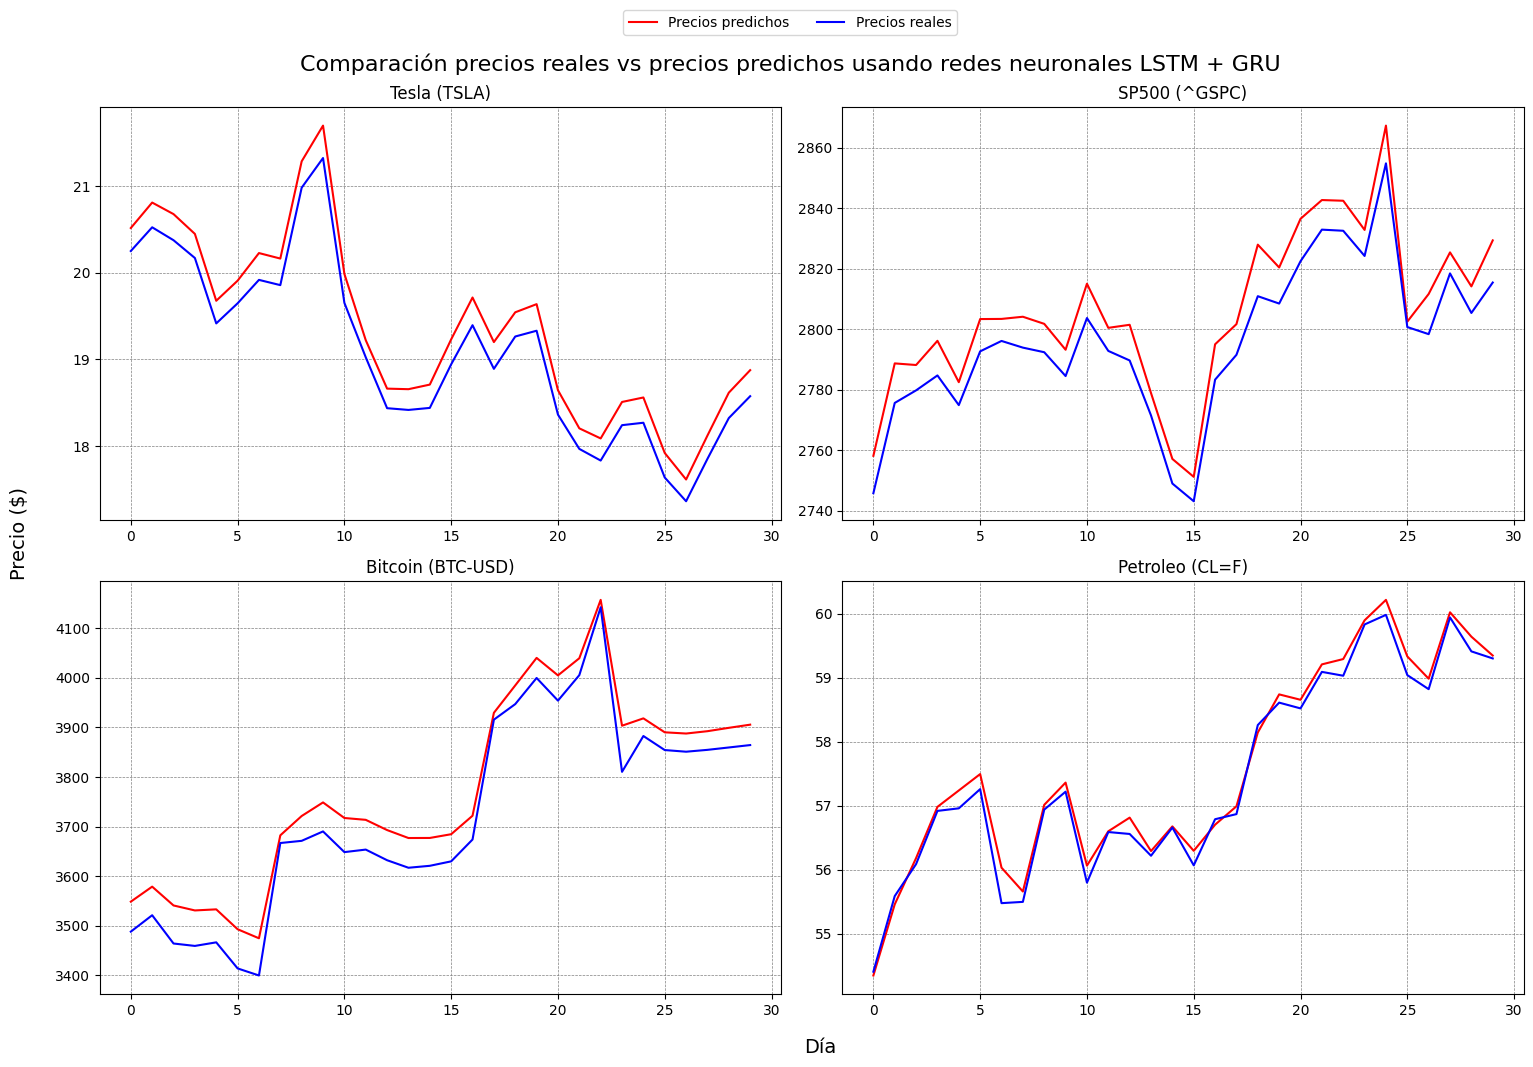

Tesla (TSLA)
RMSE:  1.3806839997154163
MSE:  1.9062883070701597
MAE:  1.1517470041910807
R²:  -6.144563505688902


SP500 (^GSPC)
RMSE:  112.47734630382539
MSE:  12651.153431550661
MAE:  110.06650390625
R²:  -19.451754278090377


Bitcoin (BTC-USD)
RMSE:  397.7235479918838
MSE:  158184.02062725226
MAE:  388.2809244791667
R²:  -54.44001961623909


Petroleo (CL=F)
RMSE:  6.895962853630586
MSE:  47.554303678652886
MAE:  6.771034749348958
R²:  -18.878122755714145




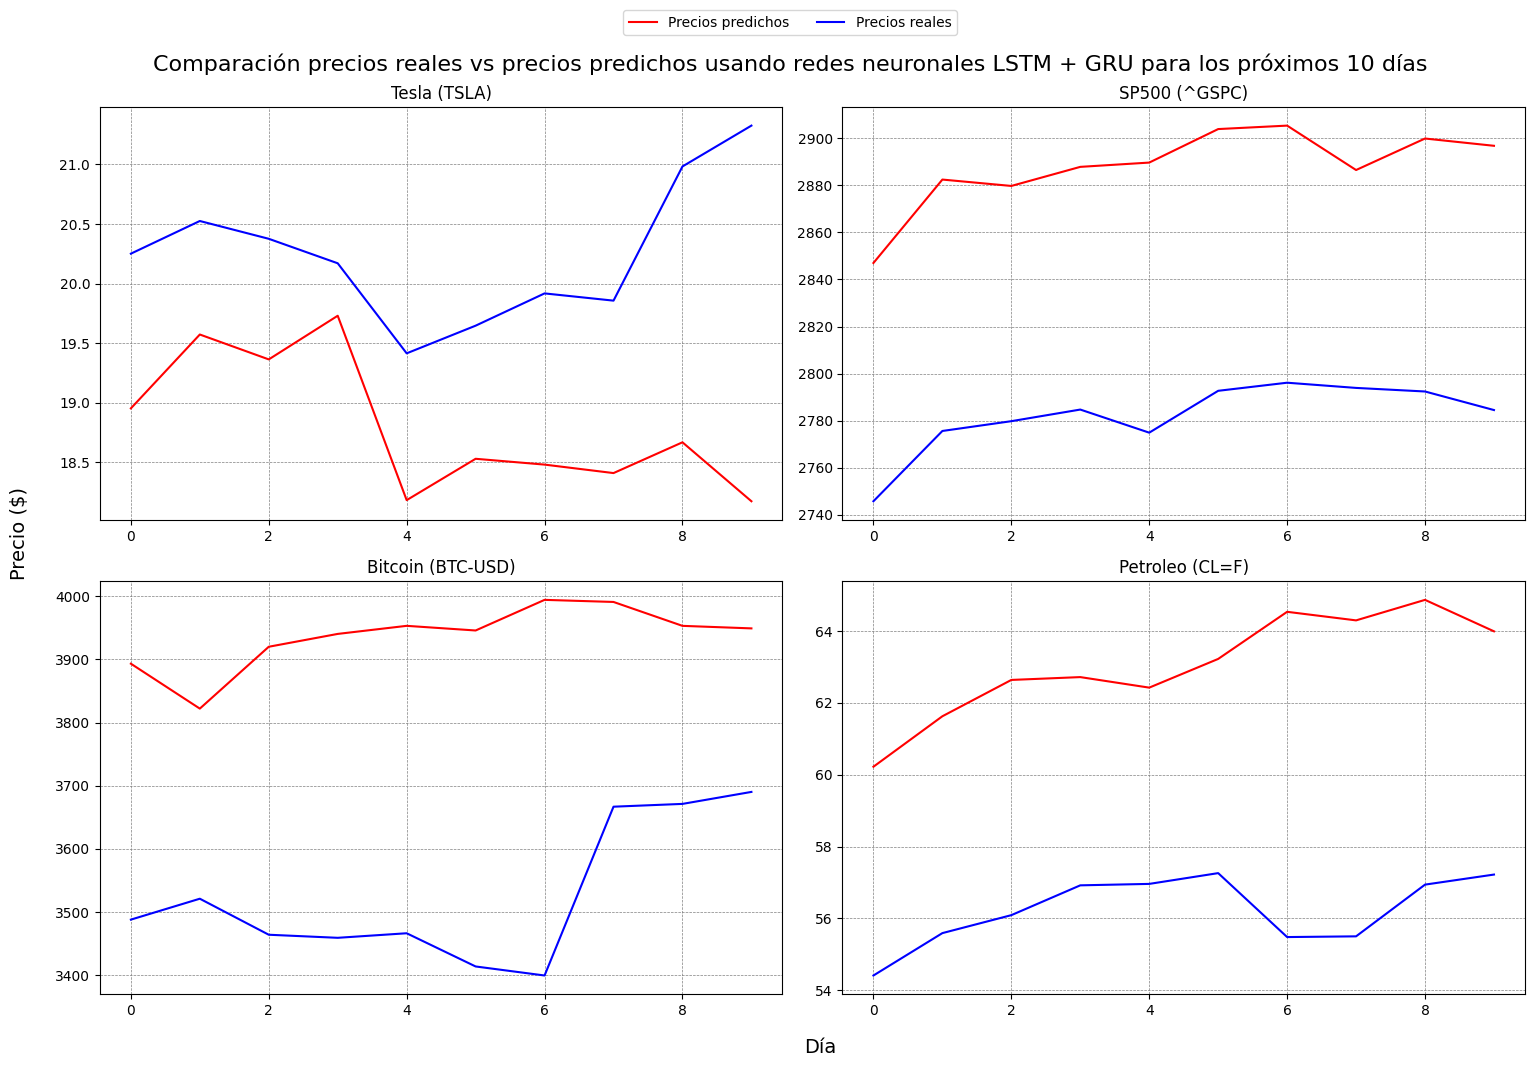

In [17]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_gru_tesla = tf.keras.models.load_model('modelos/lstm_gru_tesla.h5')
y_pred_tesla_t = lstm_gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

lstm_gru_sp500 = tf.keras.models.load_model('modelos/lstm_gru_sp500.h5')
y_pred_sp500_t = lstm_gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

lstm_gru_bitcoin = tf.keras.models.load_model('modelos/lstm_gru_bitcoin.h5')
y_pred_bitcoin_t = lstm_gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

lstm_gru_petroleo = tf.keras.models.load_model('modelos/lstm_gru_petroleo.h5')
y_pred_petroleo_t = lstm_gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [18]:
lstm_gru_tesla.summary()

Model: "sequential_596"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_993 (LSTM)             (None, None, 128)         66560     
                                                                 
 gru_988 (GRU)               (None, 128)               99072     
                                                                 
 dense_596 (Dense)           (None, 1)                 129       
                                                                 
Total params: 165,761
Trainable params: 165,761
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_gru_sp500.summary()

Model: "sequential_597"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_994 (LSTM)             (None, None, 256)         264192    
                                                                 
 lstm_995 (LSTM)             (None, None, 256)         525312    
                                                                 
 gru_989 (GRU)               (None, None, 256)         394752    
                                                                 
 gru_990 (GRU)               (None, 256)               394752    
                                                                 
 dense_597 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,579,265
Trainable params: 1,579,265
Non-trainable params: 0
_________________________________________________________________


In [20]:
lstm_gru_bitcoin.summary()

Model: "sequential_598"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_996 (LSTM)             (None, None, 512)         1052672   
                                                                 
 gru_991 (GRU)               (None, 512)               1575936   
                                                                 
 dense_598 (Dense)           (None, 1)                 513       
                                                                 
Total params: 2,629,121
Trainable params: 2,629,121
Non-trainable params: 0
_________________________________________________________________


In [21]:
lstm_gru_petroleo.summary()

Model: "sequential_599"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_997 (LSTM)             (None, None, 256)         264192    
                                                                 
 gru_992 (GRU)               (None, 256)               394752    
                                                                 
 dense_599 (Dense)           (None, 1)                 257       
                                                                 
Total params: 659,201
Trainable params: 659,201
Non-trainable params: 0
_________________________________________________________________
